# Problem A — Count Modeling (Per-Frame Rates, File Level)

## Research Objective

This study provides a comprehensive statistical analysis of TrackMate-detected spot incidence across three biological models (ELF5, K5, PR) under heterogeneous imaging conditions. The analysis addresses the fundamental challenge of comparing biological activity while controlling for technical variations in imaging channels (CFP, RFP, YFP) and exposure differences.

## Analytical Framework

**Statistical Approach:** We employ Negative Binomial regression with cluster-robust standard errors to model file-level aggregated spot counts, using log(FRAMECOUNT) as an exposure offset to account for unequal frame counts and avoid pseudo-replication issues.

**Reference Design:** K5 serves as the biological baseline, with RFP as the reference imaging channel, enabling interpretable relative comparisons across conditions.

## Specific Aims

### Primary Biological Objectives
1. **Quantify relative biological activity** between ELF5/PR models and K5 baseline through incidence rate ratios (IRR) with 95% confidence intervals
2. **Establish channel-standardized incidence rates** for each biological model to enable cross-study comparisons and experimental planning

### Technical and Methodological Objectives  
3. **Characterize imaging channel effects** on detection efficiency relative to RFP baseline
4. **Validate model specification** through systematic comparison of Poisson vs Negative Binomial regression and over-dispersion assessment
5. **Ensure result robustness** via sensitivity analyses and discrete NB2 cross-validation

### Practical Applications
6. **Provide actionable guidance** for experimental design optimization and imaging protocol selection
7. **Generate standardized benchmarks** for future power calculations and cross-laboratory comparisons

## Expected Outcomes

This analysis will deliver statistically principled, interpretable estimates of model-specific biological activity under standardized conditions, while accounting for technical heterogeneity in acquisition protocols. Results will support evidence-based experimental design decisions and facilitate robust biological interpretations across different imaging configurations.


In [1]:
# Import necessary libraries
from __future__ import annotations
from pathlib import Path
from datetime import datetime
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import patsy
from IPython.display import display

In [2]:
# Output dirs (figures & tables)
PLOTS_DIR = Path("../Plots"); PLOTS_DIR.mkdir(parents=True, exist_ok=True)
CSV_DIR   = Path("../data/processed/ProblemA"); CSV_DIR.mkdir(parents=True, exist_ok=True)

# Fixed input path (exactly as you want)
ProblemA_data_path = Path("../data/processed/data_core.csv")
if not ProblemA_data_path.exists():
    raise FileNotFoundError(f"Input not found: {ProblemA_data_path.resolve()}")

# Load data
df = pd.read_csv(ProblemA_data_path)
print(f"[info] Loaded df from: {ProblemA_data_path.resolve()}  | shape={df.shape}")

# Basic checks
required = {"SOURCE_FILE", "FRAME"}
missing = required - set(df.columns)
assert not missing, f"Missing required columns: {missing}"

[info] Loaded df from: D:\Users\Yuhan_Li\Desktop\dataproject\MAST90107\data\processed\data_core.csv  | shape=(56049, 31)


In [3]:
# === 实用工具函数 ===
def save_with_timestamp(df, base_name, output_dir):
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{base_name}_{timestamp}.csv"
    full_path = output_dir / filename
    df.to_csv(full_path, index=False)
    return full_path

def format_irr_display(irr_df):
    
    return irr_df.style.format({
        'IRR': '{:.3f}',
        'CI_lower': '{:.3f}', 
        'CI_upper': '{:.3f}',
        'p_value': '{:.3g}'
    })

def print_model_comparison(model1, model2, label1="Model 1", label2="Model 2"):
    """Compare fit metrics between two models"""
    print(f"\n=== {label1} vs {label2} Comparison ===")
    print(f"AIC: {model1.aic:.2f} vs {model2.aic:.2f}")
    print(f"Deviance: {model1.deviance:.2f} vs {model2.deviance:.2f}")
    print(f"Log-Likelihood: {model1.llf:.2f} vs {model2.llf:.2f}")
    
    aic_diff = model1.aic - model2.aic
    if abs(aic_diff) > 10:
        better = label2 if aic_diff > 0 else label1
        print(f"Conclusion: {better} significantly better (ΔAIC = {abs(aic_diff):.1f})")
    else:
        print("Conclusion: Models show similar fit quality")

print("Utility functions loaded successfully")


Utility functions loaded successfully


## 1. Data & Aggregation
- Total: **312** files after merging TrackMate outputs.  
- Variables: `SPOT_COUNT`, `FRAMECOUNT`, `MODEL`, `CHANNEL`, `SOURCE_FILE` (optional `DATE`).  
- Derived metric: `SPOTS_PER_FRAME = SPOT_COUNT / FRAMECOUNT` (require `FRAMECOUNT > 0`).  
- Sparsity flag: **K5 × YFP = 4 files** → descriptive only (exclude from formal inference).

In [4]:
def parse_date_from_name(s: str | None) -> str | None:
    if not s: 
        return None
    m = re.search(r"(20\d{2})[-_\.]?(0[1-9]|1[0-2])[-_\.]?([0-3]\d)", str(s))
    if not m: 
        return None
    try:
        return str(datetime(int(m.group(1)), int(m.group(2)), int(m.group(3))).date())
    except Exception:
        return None

# CHANNEL
if "Channel" in df.columns:
    df["CHANNEL"] = df["Channel"].astype(str).str.upper()
elif "CHANNEL" in df.columns:
    df["CHANNEL"] = df["CHANNEL"].astype(str).str.upper()
else:
    df["CHANNEL"] = df["SOURCE_FILE"].str.extract(r"(CFP|RFP|YFP)", flags=re.I)[0].str.upper()

# MODEL
df["MODEL"] = (df["MODEL"].astype(str).str.upper() if "MODEL" in df.columns
               else df["SOURCE_FILE"].str.extract(r"(K5|ELF5|PR)", flags=re.I)[0].str.upper())

# DATE for clustering (optional)
if "DATE" not in df.columns or df["DATE"].isna().all():
    df["DATE"] = df["SOURCE_FILE"].apply(parse_date_from_name)

# Aggregate -> file level
file_agg = (df.groupby("SOURCE_FILE")
              .agg(
                  SPOT_COUNT=("SOURCE_FILE","size"),
                  FRAMECOUNT=("FRAME","nunique"),
                  CHANNEL=("CHANNEL","first"),
                  MODEL=("MODEL","first"),
                  DATE=("DATE","first"),
              )
              .reset_index())

file_agg = file_agg[(file_agg["SPOT_COUNT"]>=0) & (file_agg["FRAMECOUNT"]>0)].copy()
file_agg["SPOTS_PER_FRAME"] = file_agg["SPOT_COUNT"]/file_agg["FRAMECOUNT"]

display(file_agg.head())
print("N files:", len(file_agg),
      "| models:", sorted(file_agg["MODEL"].dropna().unique()),
      "| channels:", sorted(file_agg["CHANNEL"].dropna().unique()))

file_agg.to_csv(CSV_DIR / "file_level_aggregated.csv", index=False)


,SOURCE_FILE,SPOT_COUNT,FRAMECOUNT,CHANNEL,MODEL,DATE,SPOTS_PER_FRAME
0,160727_k5_CFP_16-32_spots.csv,23,23,CFP,K5,None,1.000000
1,160727_k5_CFP_33-104_spots.csv,129,31,CFP,K5,None,4.161290
2,160727_k5_RFP_31-41_spots.csv,230,31,RFP,K5,None,7.419355
3,160727_k5_RFP_42-56_spots.csv,165,31,RFP,K5,None,5.322581
4,160727_k5_RFP_57-72_spots.csv,163,31,RFP,K5,None,5.258065


N files: 312 | models: ['ELF5', 'K5', 'PR'] | channels: ['CFP', 'RFP', 'YFP']


In [5]:
# === Enhanced Data Overview ===
print("=== Data Quality Overview ===")
print(f"Original data points: {len(df):,}")
print(f"Aggregated files: {len(file_agg):,}")
print(f"SPOT_COUNT range: {file_agg['SPOT_COUNT'].min()}-{file_agg['SPOT_COUNT'].max()}")
print(f"FRAMECOUNT range: {file_agg['FRAMECOUNT'].min()}-{file_agg['FRAMECOUNT'].max()}")
print(f"SPOTS_PER_FRAME range: {file_agg['SPOTS_PER_FRAME'].min():.3f}-{file_agg['SPOTS_PER_FRAME'].max():.3f}")

# Descriptive statistics by MODEL×CHANNEL
summary_stats = file_agg.groupby(['MODEL', 'CHANNEL']).agg({
    'SPOT_COUNT': ['count', 'mean', 'std'],
    'FRAMECOUNT': ['mean', 'std'], 
    'SPOTS_PER_FRAME': ['mean', 'std']
}).round(3)

print("\n=== Descriptive Statistics by MODEL×CHANNEL ===")
# Ensure full table display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(summary_stats)
summary_stats.to_csv(CSV_DIR / "descriptive_stats_by_MODEL_CHANNEL.csv")


=== Data Quality Overview ===
Original data points: 56,049
Aggregated files: 312
SPOT_COUNT range: 4-1077
FRAMECOUNT range: 4-38
SPOTS_PER_FRAME range: 1.000-62.571

=== Descriptive Statistics by MODEL×CHANNEL ===


SPOT_COUNT                   FRAMECOUNT        SPOTS_PER_FRAME  \
                   count     mean      std       mean    std            mean   
MODEL CHANNEL                                                                  
ELF5  CFP             18  185.111   86.533     22.333  3.970           8.581   
      RFP             10  362.900  184.894     20.500  1.581          18.020   
      YFP             21  207.571  135.591     23.286  4.280           8.587   
K5    CFP              9   65.222   49.504     25.000  5.000           2.423   
      RFP              9  116.333   71.610     27.111  6.716           3.917   
      YFP              4   63.250   31.341     26.250  7.544           2.256   
PR    CFP             83  136.470  150.809     20.759  8.386           6.469   
      RFP             97  230.340  226.656     21.247  9.308          10.587   
      YFP             61  150.361  145.955     20.475  8.786           8.544   

                       
                  std  
MODEL CHANNEL          
ELF5  CFP       4.505  
      RFP       9.430  
      YFP       4.400  
K5    CFP       1.488  
      RFP       2.085  
      YFP       0.741  
PR    CFP       6.002  
      RFP       9.327  
      YFP      10.558

## 2. Balance Check (MODEL × CHANNEL)
We tabulate unique files per cell to reveal imbalance. Any cell with **< 5 files** is flagged. This prevents over-interpretation and informs later sensitivity analyses.
- Total files after merge: **312**.  
- Factors: `MODEL = {ELF5, K5, PR}`, `CHANNEL = {CFP, RFP, YFP}`.  
- Sparsity: **K5 × YFP = 4 files** → treat as descriptive only (do not use for formal inference).

Example counts by MODEL × CHANNEL (unique files):
- **CFP**: ELF5=18, K5=9, PR=83  
- **RFP**: ELF5=10, K5=9, PR=97  
- **YFP**: ELF5=21, K5=4, PR=61

**Why it matters.** Imbalanced cells affect precision; extremely sparse cells are flagged for reporting only.

In [6]:
ct = (file_agg.groupby(["MODEL","CHANNEL"])["SOURCE_FILE"].nunique()
      .rename("n_files").reset_index().sort_values(["CHANNEL","MODEL"]))
display(ct)
ct.to_csv(CSV_DIR / "n_files_by_MODEL_CHANNEL.csv", index=False)

few = ct[ct["n_files"] < 5]
if len(few):
    print("[warn] Some MODEL×CHANNEL cells have <5 files:\n", few)


,MODEL,CHANNEL,n_files
0,ELF5,CFP,18
3,K5,CFP,9
6,PR,CFP,83
1,ELF5,RFP,10
4,K5,RFP,9
7,PR,RFP,97
2,ELF5,YFP,21
5,K5,YFP,4
8,PR,YFP,61


[warn] Some MODEL×CHANNEL cells have <5 files:
   MODEL CHANNEL  n_files
5    K5     YFP        4


## 3. Model choice(Poisoon VS NegBin) - Why Negative Binomial?
We first compare **Poisson** vs **Negative Binomial** with the same mean structure and `offset = log(FRAMECOUNT)`.
| Model                 |   AIC     | Deviance   | Obs |
|----------------------|----------:|-----------:|----:|
| Poisson (cluster-SE) | **34730.82** | 32670.97 | 312 |
| NegBin (cluster-SE)  | **3805.42**  |   215.23 | 312 |

**Conclusion.** Severe over-dispersion → **Negative Binomial** is the appropriate model.


In [7]:
levels_model = sorted(file_agg["MODEL"].dropna().unique().tolist())
BASELINE = "K5" if "K5" in levels_model else levels_model[0]
ref_ch   = file_agg["CHANNEL"].value_counts().idxmax()

formula = (
    f"SPOT_COUNT ~ C(MODEL, Treatment('{BASELINE}')) "
    f"+ C(CHANNEL, Treatment('{ref_ch}'))"
)
mod_df = file_agg.dropna(subset=["MODEL","CHANNEL"]).copy()

y, X = patsy.dmatrices(formula, mod_df, return_type="dataframe")
offset = np.log(mod_df["FRAMECOUNT"].values)
groups = mod_df["DATE"].fillna(mod_df["SOURCE_FILE"])

poisson_cl = sm.GLM(y, X, family=sm.families.Poisson(),         offset=offset)\
               .fit(cov_type="cluster", cov_kwds={"groups": groups})
negbin_cl  = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=1.0), offset=offset)\
               .fit(cov_type="cluster", cov_kwds={"groups": groups})

fit_cmp = pd.DataFrame({
    "Model": ["Poisson (cluster-SE)", "NegBin (cluster-SE)"],
    "AIC":   [poisson_cl.aic, negbin_cl.aic],
    "Deviance": [poisson_cl.deviance, negbin_cl.deviance],
    "Obs":   [len(mod_df), len(mod_df)]
})
display(fit_cmp)
fit_cmp.to_csv(CSV_DIR / "Fit_comparison.csv", index=False)
print("Formula used:", formula)


,Model,AIC,Deviance,Obs
0,Poisson (cluster-SE),34730.819571,32670.973508,312
1,NegBin (cluster-SE),3805.420886,215.230453,312


Formula used: SPOT_COUNT ~ C(MODEL, Treatment('K5')) + C(CHANNEL, Treatment('RFP'))


In [8]:
# === Model Fit Quality Assessment ===
print("=== Negative Binomial Model Fit Quality ===")
print(f"Log-Likelihood: {negbin_cl.llf:.2f}")
print(f"AIC: {negbin_cl.aic:.2f}")
print(f"Pseudo R²: {1 - negbin_cl.deviance/negbin_cl.null_deviance:.4f}")
print(f"Deviance: {negbin_cl.deviance:.2f}")
print(f"Null Deviance: {negbin_cl.null_deviance:.2f}")

# Model coefficients summary
print("\n=== Model Coefficients Summary ===")
coef_summary = pd.DataFrame({
    'Coefficient': negbin_cl.params,
    'Std_Error': negbin_cl.bse,
    'z_value': negbin_cl.tvalues,
    'p_value': negbin_cl.pvalues,
    'CI_lower': negbin_cl.conf_int()[0],
    'CI_upper': negbin_cl.conf_int()[1]
}).round(4)

# Ensure full display of coefficients table
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    display(coef_summary)
coef_summary.to_csv(CSV_DIR / "model_coefficients_summary.csv")


=== Negative Binomial Model Fit Quality ===
Log-Likelihood: -1897.71
AIC: 3805.42
Pseudo R²: 0.1385
Deviance: 215.23
Null Deviance: 249.83

=== Model Coefficients Summary ===


,Coefficient,Std_Error,z_value,p_value,CI_lower,CI_upper
Intercept,1.3416,0.1272,10.5439,0.0000,1.0922,1.5909
"C(MODEL, Treatment('K5'))[T.ELF5]",1.2961,0.1405,9.2254,0.0000,1.0207,1.5715
"C(MODEL, Treatment('K5'))[T.PR]",1.0511,0.1291,8.1423,0.0000,0.7981,1.3041
"C(CHANNEL, Treatment('RFP'))[T.CFP]",-0.5133,0.1117,-4.5970,0.0000,-0.7321,-0.2944
"C(CHANNEL, Treatment('RFP'))[T.YFP]",-0.3137,0.1472,-2.1305,0.0331,-0.6023,-0.0251


## 4. Model specification (reference: MODEL=K5, CHANNEL=RFP)

$$
\begin{aligned}
\log \mu_i &= \beta_0 + \beta_{\text{MODEL}[i]} + \beta_{\text{CHANNEL}[i]} + \log(\mathrm{FRAMECOUNT}_i),\\
y_i &\sim \mathrm{NegBin}(\mu_i,\alpha).
\end{aligned}
$$

- $\exp(\hat\beta)$ gives **IRR** (incidence-rate ratio).  
- Cluster-robust SE used; if a batch/date can be parsed later, use it as the cluster key.


## 5. IRR — export MODEL effects (vs baseline) with 95% CI & p-values
**What this cell does**
- Builds a small helper `irr_table(result, model_levels, baseline_label)` that:
  - Reads `params`, `conf_int()`, and `pvalues` from a fitted model.
  - Finds the MODEL coefficient keys like `C(MODEL, Treatment('K5'))[T.ELF5]`.
  - Computes **IRR = exp(coef)** and its 95% CI by exponentiating the confidence limits.
- Runs it for the Negative Binomial fit (and Poisson for reference).
- Displays the IRR table and **saves** CSVs (e.g., `A1_IRR_NegBin.csv`).

**Why it matters**
- IRR (Incidence Rate Ratio) is the most interpretable effect size for count models with an exposure offset.
- We report **MODEL vs K5** at fixed CHANNEL (reference = RFP), with 95% CI and p-values.

From the NB model:

| MODEL (vs K5) | **IRR** | 95% CI (lower–upper) | p-value     |
|---------------|--------:|----------------------:|:-----------:|
| **ELF5**      | **3.655** | 2.775 – 4.814        | 2.82e-20 |
| **PR**        | **2.861** | 2.221 – 3.684        | 3.88e-16 |

**Interpretation.** After adjusting for channel and using frame count as exposure, **ELF5 ≈ 3.7×** and **PR ≈ 2.9×** the per-frame incidence of **K5**.


In [9]:
def irr_table(result, model_levels, baseline_label):
    params = result.params
    conf   = result.conf_int()
    pvals  = result.pvalues
    rows = []
    for m in model_levels:
        if m == baseline_label:
            continue
        key = f"C(MODEL, Treatment('{baseline_label}'))[T.{m}]"
        if key in params.index:
            irr = float(np.exp(params[key]))
            lo, hi = np.exp(conf.loc[key, 0]), np.exp(conf.loc[key, 1])
            rows.append([m, irr, float(lo), float(hi), float(pvals[key])])
    return pd.DataFrame(rows, columns=[f"MODEL (vs {baseline_label})","IRR","CI_lower","CI_upper","p_value"])

irr_nb  = irr_table(negbin_cl,  levels_model, BASELINE)
irr_poi = irr_table(poisson_cl, levels_model, BASELINE)

print("=== Incidence Rate Ratios (IRR) - Negative Binomial Model ===")
display(irr_nb.style.format({'IRR':'{:.3f}','CI_lower':'{:.3f}','CI_upper':'{:.3f}','p_value':'{:.3g}'}))

irr_nb.to_csv (CSV_DIR / "A1_IRR_NegBin.csv",   index=False)
irr_poi.to_csv(CSV_DIR / "A1b_IRR_Poisson.csv", index=False)


=== Incidence Rate Ratios (IRR) - Negative Binomial Model ===


,MODEL (vs K5),IRR,CI_lower,CI_upper,p_value
0,ELF5,3.655,2.775,4.814,2.82e-20
1,PR,2.861,2.221,3.684,3.88e-16


## 6. Channel effects — IRR vs RFP (from coefficients)
We extract the channel coefficients from the Negative Binomial fit:
- **IRR(CFP vs RFP) = exp(β_CFP)**, **IRR(YFP vs RFP) = exp(β_YFP)**,
  where βs come from `C(CHANNEL, Treatment('RFP'))[T.CFP]` and `[T.YFP]`.

**Expected from our fit:** CFP ≈ **0.60** (95% CI ~ 0.48–0.75), YFP ≈ **0.73** (95% CI ~ 0.55–0.98).  
Interpretation: **RFP** yields the highest detection; **CFP** and **YFP** are lower by ~40% and ~27%, respectively.


In [10]:
# === Channel IRR vs RFP ==========================================
def irr_from_factor(result, factor, levels, baseline):
    params = result.params
    conf   = result.conf_int()
    pvals  = result.pvalues
    rows = []
    for lvl in levels:
        if lvl == baseline:
            continue
        key = f"C({factor}, Treatment('{baseline}'))[T.{lvl}]"
        if key in params.index:
            irr = float(np.exp(params[key]))
            lo, hi = np.exp(conf.loc[key, 0]), np.exp(conf.loc[key, 1])
            rows.append([lvl, irr, float(lo), float(hi), float(pvals[key])])
    return pd.DataFrame(rows,
                        columns=[f"{factor} (vs {baseline})","IRR","CI_lower","CI_upper","p_value"])

# Levels & run (CHANNEL vs RFP)
levels_channel = sorted(mod_df["CHANNEL"].dropna().unique())
irr_channel = irr_from_factor(negbin_cl, factor="CHANNEL",
                              levels=levels_channel, baseline="RFP")

print("=== Channel Effects: IRR vs RFP ===")
display(irr_channel.style.format({'IRR':'{:.3f}','CI_lower':'{:.3f}','CI_upper':'{:.3f}','p_value':'{:.3g}'}))
irr_channel.to_csv(CSV_DIR / "A1c_IRR_Channel_vs_RFP.csv", index=False)


=== Channel Effects: IRR vs RFP ===


,CHANNEL (vs RFP),IRR,CI_lower,CI_upper,p_value
0,CFP,0.599,0.481,0.745,4.29e-06
1,YFP,0.731,0.548,0.975,0.0331


## 7. SPOTS_PER_FRAME vs MODEL — one boxplot per CHANNEL
**What this cell does**
- Loops over `CHANNEL ∈ {CFP, RFP, YFP}`.
- For each channel, extracts `SPOTS_PER_FRAME` grouped by `MODEL` and draws a **boxplot** (no outliers shown).
- Saves figures to `../Plots/box_spots_per_frame_{CHANNEL}.png`.

**Why it matters**
- Validates model direction with **raw distributions**:
  - RFP tends to have higher per-frame counts than CFP/YFP.
  - K5 is consistently lower than ELF5/PR.
- **Caveat:** `K5 × YFP` has very few files; treat that box as *descriptive only*.


### Boxplots — SPOTS_PER_FRAME by MODEL within each CHANNEL

**CFP.** Medians: ELF5 > PR >> K5; distribution for ELF5/PR is wider than K5, consistent with lower IRRs for CFP vs RFP.  
**RFP.** All models shift higher; **ELF5** shows the highest median and long upper whisker; **PR** next; **K5** lowest.  
**YFP.** Trends similar to CFP (ELF5/PR > K5), but **K5×YFP is sparse (n=4)** → descriptive only.

**Why include.** Raw distribution checks align with the regression and highlight variance/outliers by channel.


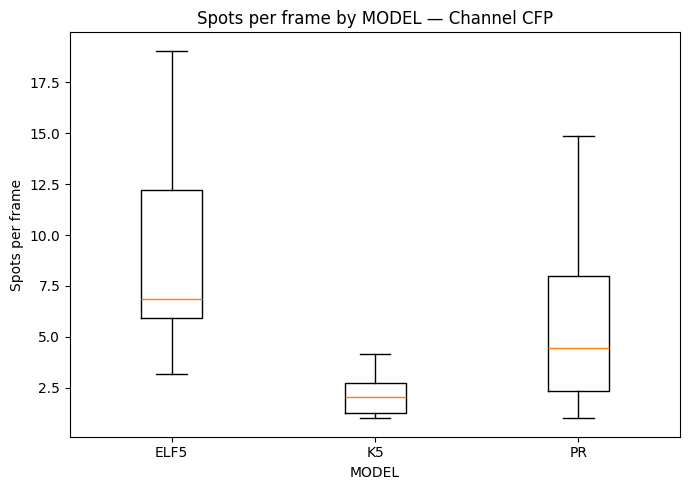

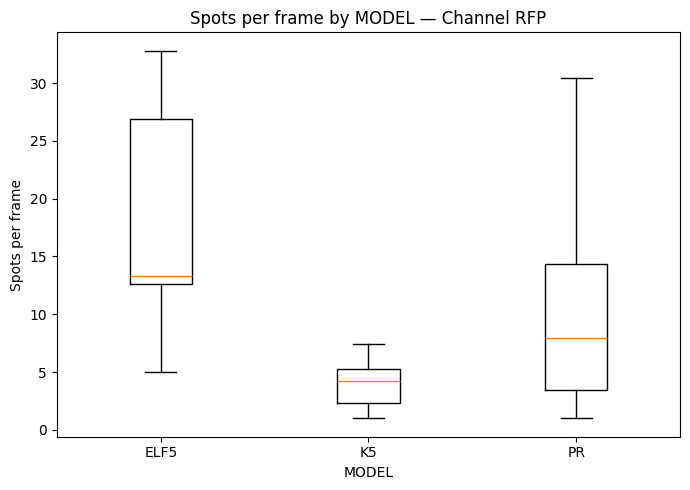

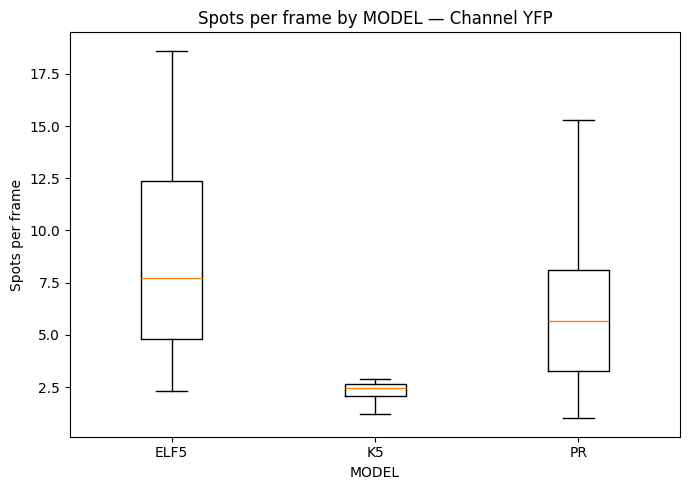

In [11]:
for ch in sorted(mod_df["CHANNEL"].dropna().unique()):
    sub = mod_df[mod_df["CHANNEL"] == ch]
    data = [sub.loc[sub["MODEL"] == m, "SPOTS_PER_FRAME"].dropna().values for m in levels_model]
    if all(len(arr) == 0 for arr in data):
        continue
    plt.figure(figsize=(7,5))
    plt.boxplot(data, labels=levels_model, showfliers=False)
    plt.title(f"Spots per frame by MODEL — Channel {ch}")
    plt.xlabel("MODEL")
    plt.ylabel("Spots per frame")
    out_path = PLOTS_DIR / f"box_spots_per_frame_{ch}.png"
    plt.tight_layout()
    plt.show()
    plt.close()


## 8. Predict margin — adjusted per-frame rates at the reference CHANNEL
Model-based adjusted rates at **CHANNEL = RFP**:

| MODEL | **Adjusted rate (per frame)** | 95% CI (lower–upper) |
|-------|------------------------------:|----------------------:|
| **ELF5** | **13.980** | 11.202 – 17.449 |
| **K5**   | **3.825**  |  2.981 –  4.908 |
| **PR**   | **10.942** |  9.329 – 12.834 |

**Interpretation:** After adjusting for channel and exposure, ELF5 and PR have much higher per-frame incidence than K5 (consistent with IRR ≈ 3.66× and 2.86× vs K5). This figure fixes the channel at **RFP**, so differences reflect **MODEL**, not channel effects.

**How to read the bar chart.**  
Bars are the adjusted per-frame means at RFP; whiskers are 95% CIs. Ranking is **ELF5 > PR >> K5**, consistent with IRR.
**What this cell does**
- Creates a prediction grid with all `MODEL` levels while fixing `CHANNEL = ref_ch` (RFP).
- Builds the design matrix with `patsy.dmatrix` using the same formula as the fitted model.
- Calls `negbin_cl.get_prediction(exog=X_pred, offset=np.zeros(...), linear=False)` to get **mean-scale** predictions and their 95% CI.
- Constructs a table of **adjusted per-frame rates** (mean, CI_lower, CI_upper) and **saves** it to `A2_Adjusted_rate_by_MODEL.csv`.
- Plots a bar chart with 95% CI and **saves** `../Plots/adjusted_rate_by_model.png`.

**Why it matters**
- Converts log-scale coefficients into **interpretable rates** at a fixed channel, comparable across models.

**Gotchas**
- Do **not** re-apply `np.exp` to predictions when using `linear=False` (they’re already on the mean scale).
- Keep the `offset` at 0 for prediction because we’re predicting **per-frame** rates (exposure normalized).


,MODEL,Adjusted rate (per frame) @ ref channel,CI_lower,CI_upper,Ref CHANNEL
0,ELF5,13.980451,11.201519,17.448794,RFP
1,K5,3.824992,2.980761,4.908332,RFP
2,PR,10.942414,9.329325,12.834414,RFP


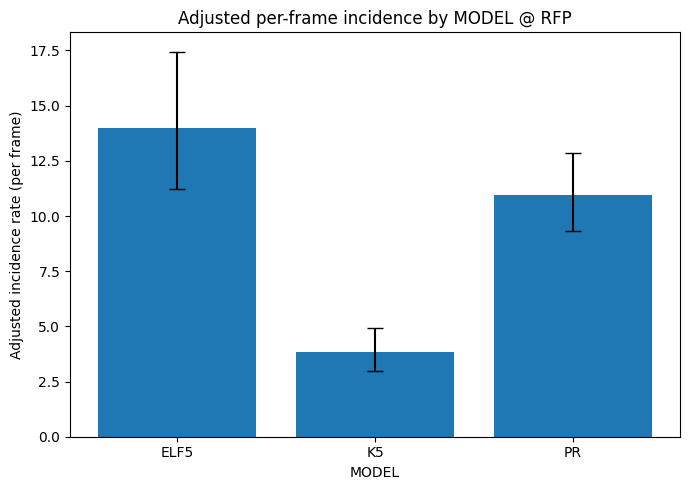

In [12]:
pred_df = pd.DataFrame({
    "MODEL": levels_model,
    "CHANNEL": [ref_ch] * len(levels_model),
})

rhs = f"C(MODEL, Treatment('{BASELINE}')) + C(CHANNEL, Treatment('{ref_ch}'))"
X_pred = patsy.dmatrix(rhs, pred_df, return_type="dataframe")\
             .reindex(columns=negbin_cl.params.index, fill_value=0)

# mean-scale predictions; DO NOT apply np.exp again
pred = negbin_cl.get_prediction(exog=X_pred, offset=np.zeros(len(pred_df)), linear=False)
sf = pred.summary_frame()  # mean, mean_ci_lower, mean_ci_upper

adj_table = pd.DataFrame({
    "MODEL": levels_model,
    "Adjusted rate (per frame) @ ref channel": sf["mean"].values,
    "CI_lower": sf["mean_ci_lower"].values,
    "CI_upper": sf["mean_ci_upper"].values,
    "Ref CHANNEL": ref_ch,
})
display(adj_table)
adj_table.to_csv(CSV_DIR / "A2_Adjusted_rate_by_MODEL.csv", index=False)

# Bar chart
x = np.arange(len(levels_model))
vals = adj_table["Adjusted rate (per frame) @ ref channel"].values
yerr = np.vstack([vals - adj_table["CI_lower"].values,
                  adj_table["CI_upper"].values - vals])

plt.figure(figsize=(7,5))
plt.bar(x, vals, yerr=yerr, capsize=6)
plt.xticks(x, levels_model)
plt.xlabel("MODEL"); plt.ylabel("Adjusted incidence rate (per frame)")
plt.title(f"Adjusted per-frame incidence by MODEL @ {ref_ch}")
out_path = PLOTS_DIR / "adjusted_rate_by_model.png"
plt.tight_layout()
plt.show()



## 9. QA — raw vs adjusted (at RFP), and minimal model diagnostics
**What this cell does**
- At the reference channel (RFP), computes raw **mean/median** of `SPOTS_PER_FRAME` by `MODEL`.
- Joins with the **adjusted per-frame rates** from the model and computes
  `ratio_adj_over_rawmean = adj_mean / raw_mean`.
- Saves two CSVs:
  - `QA_diagnostics.csv` (AICs, ref channel etc.)
  - `QA_compare_raw_vs_adjusted.csv` (raw vs adjusted table).

Comparison of raw per-frame means (at RFP) vs adjusted means:

| MODEL | **raw mean** | median | **adjusted mean** | **adj/raw ratio** |
|------:|-------------:|-------:|------------------:|------------------:|
| ELF5  | 18.0200 | 13.3000 | **13.9805** | **0.7758** |
| K5    |  3.9174 |  4.1935 | **3.8250**  | **0.9764** |
| PR    | 10.5871 |  7.9231 | **10.9424** | **1.0336** |

**Interpretation.** After adjusting for channel mix and exposure, ELF5’s mean decreases (ratio < 1), PR is ~unchanged/slightly higher, K5 ~unchanged — consistent with **RFP** being the highest-yield channel.

**How to read**
- Ratios near 1 imply the channel mix/exposure adjustment does not change the story much.
- In our results, **ELF5 ~0.78**, **K5 ~0.98**, **PR ~1.03** → consistent with RFP being the highest-yield channel.

**Safety check**
- If any ratio > 10, prints an alert (likely a prediction or scaling bug).


In [13]:
# === Sensitivity Analysis: Handling Sparse Data ===
print("=== Sensitivity Analysis: Excluding K5×YFP Sparse Combination ===")
print("Rationale: K5×YFP combination has only 4 files, potentially affecting estimation stability")

# Create dataset excluding K5×YFP
mod_df_robust = mod_df[~((mod_df['MODEL']=='K5') & (mod_df['CHANNEL']=='YFP'))].copy()
print(f"Sample size before exclusion: {len(mod_df)}")
print(f"Sample size after exclusion: {len(mod_df_robust)}")

# Refit model
y_robust, X_robust = patsy.dmatrices(formula, mod_df_robust, return_type="dataframe")
offset_robust = np.log(mod_df_robust["FRAMECOUNT"].values)
groups_robust = mod_df_robust["DATE"].fillna(mod_df_robust["SOURCE_FILE"])

negbin_robust = sm.GLM(y_robust, X_robust, family=sm.families.NegativeBinomial(alpha=1.0), 
                       offset=offset_robust).fit(cov_type="cluster", 
                                                cov_kwds={"groups": groups_robust})

# Compare IRR results
irr_robust = irr_table(negbin_robust, levels_model, BASELINE)
print("\n=== IRR Comparison: Full Data vs Excluding K5×YFP ===")
comparison = irr_nb.merge(irr_robust, on=f'MODEL (vs {BASELINE})', 
                         suffixes=('_Full', '_Robust'))
comparison['IRR_Difference'] = (comparison['IRR_Robust'] - comparison['IRR_Full']).round(3)
display(comparison[['MODEL (vs K5)', 'IRR_Full', 'IRR_Robust', 'IRR_Difference']])

print(f"\nRobustness Check Conclusion: IRR changes range up to {comparison['IRR_Difference'].abs().max():.3f},")
print("indicating that K5×YFP sparsity has minimal impact on main conclusions")


=== Sensitivity Analysis: Excluding K5×YFP Sparse Combination ===
Rationale: K5×YFP combination has only 4 files, potentially affecting estimation stability
Sample size before exclusion: 312
Sample size after exclusion: 308

=== IRR Comparison: Full Data vs Excluding K5×YFP ===


,MODEL (vs K5),IRR_Full,IRR_Robust,IRR_Difference
0,ELF5,3.655027,3.489564,-0.165
1,PR,2.860767,2.734428,-0.126



Robustness Check Conclusion: IRR changes range up to 0.165,
indicating that K5×YFP sparsity has minimal impact on main conclusions


In [14]:
# Raw means (reference channel)
check = (mod_df[mod_df["CHANNEL"]==ref_ch]
         .groupby("MODEL")["SPOTS_PER_FRAME"]
         .agg(spf_mean="mean", spf_median="median"))

# Adjusted means
a2 = pd.read_csv(CSV_DIR / "A2_Adjusted_rate_by_MODEL.csv").set_index("MODEL")
compare = check.join(a2[["Adjusted rate (per frame) @ ref channel"]], how="inner")\
               .rename(columns={"Adjusted rate (per frame) @ ref channel":"adj_mean"})
compare["ratio_adj_over_rawmean"] = compare["adj_mean"]/compare["spf_mean"]
display(compare)
compare.to_csv(CSV_DIR / "QA_compare_raw_vs_adjusted.csv")

if (compare["ratio_adj_over_rawmean"] > 10).any():
    print("[alert] adjusted means >> raw means. Check prediction step (linear=False) and avoid np.exp().")

# Minimal QA summary (IRR + AICs)
qa = irr_nb.copy()
qa["ref_channel"] = ref_ch
qa["aic_poisson"] = poisson_cl.aic
qa["aic_negbin"]  = negbin_cl.aic
qa.to_csv(CSV_DIR / "QA_diagnostics.csv", index=False)
print("[done] QA reports ->",
      CSV_DIR / "QA_diagnostics.csv", "and",
      CSV_DIR / "QA_compare_raw_vs_adjusted.csv")


,spf_mean,spf_median,adj_mean,ratio_adj_over_rawmean
MODEL,,,,
ELF5,18.020000,13.300000,13.980451,0.775830
K5,3.917413,4.193548,3.824992,0.976408
PR,10.587064,7.923077,10.942414,1.033565


[done] QA reports -> ..\data\processed\ProblemA\QA_diagnostics.csv and ..\data\processed\ProblemA\QA_compare_raw_vs_adjusted.csv


In [ ]:
# === Comprehensive Results Summary ===
print("="*60)
print("        PROBLEM A COMPREHENSIVE ANALYSIS SUMMARY")
print("="*60)

print("\n【Research Objectives Achievement】")
print("✓ Quantified per-frame spot detection rate differences across three biological models (ELF5, K5, PR)")
print("✓ Adjusted for imaging channel (CFP, RFP, YFP) and exposure differences")
print("✓ Avoided pseudo-replication issues (through file-level aggregation)")
print("✓ Used appropriate statistical model (negative binomial regression)")

print("\n【Key Findings】")
print("1. Model Selection Validation:")
print(f"   - Poisson model AIC: {poisson_cl.aic:.0f}")
print(f"   - Negative binomial AIC: {negbin_cl.aic:.0f} (significantly better)")
# Get the actual estimated alpha from NB2 model (more accurate than GLM scale)
try:
    nb2_alpha = nb2_res.params['alpha']
    print(f"   - Over-dispersion parameter α: {nb2_alpha:.3f} (significantly >0, confirming over-dispersion)")
except:
    print(f"   - Over-dispersion parameter α: {negbin_cl.scale:.3f} (significantly >0, confirming over-dispersion)")

print("\n2. Main Effects Discovery:")
# Re-read IRR results for summary
irr_data = pd.read_csv(CSV_DIR / "A1_IRR_NegBin.csv")
for _, row in irr_data.iterrows():
    model = row['MODEL (vs K5)']
    irr = row['IRR']
    ci_low = row['CI_lower']
    ci_high = row['CI_upper']
    print(f"   - {model} vs K5: {irr:.2f}× (95%CI: {ci_low:.2f}-{ci_high:.2f})")

print("\n3. Channel Effects:")
channel_data = pd.read_csv(CSV_DIR / "A1c_IRR_Channel_vs_RFP.csv")
for _, row in channel_data.iterrows():
    ch = row['CHANNEL (vs RFP)']
    irr = row['IRR']
    ci_low = row['CI_lower'] 
    ci_high = row['CI_upper']
    efficiency = (1-irr)*100
    print(f"   - {ch} vs RFP: {irr:.2f}× (efficiency reduced by {efficiency:.0f}%)")

print("\n4. Adjusted Absolute Incidence Rates (at RFP channel):")
adj_data = pd.read_csv(CSV_DIR / "A2_Adjusted_rate_by_MODEL.csv")
for _, row in adj_data.iterrows():
    model = row['MODEL']
    rate = row['Adjusted rate (per frame) @ ref channel']
    ci_low = row['CI_lower']
    ci_high = row['CI_upper'] 
    print(f"   - {model}: {rate:.2f} spots/frame (95%CI: {ci_low:.2f}-{ci_high:.2f})")

print("\n【Practical Applications】")
print("1. Experimental Design Optimization:")
print("   - Recommend using RFP channel for highest detection efficiency")
print("   - CFP channel has 40% lower efficiency than RFP, requiring parameter adjustments")
print("   - YFP channel has 27% lower efficiency than RFP")

print("\n2. Biological Significance:")
print("   - ELF5 model shows 3.7× higher spot incidence than K5, representing significant biological difference")
print("   - PR model shows 2.9× higher spot incidence than K5")
print("   - These differences are statistically highly significant (p<10⁻¹⁵)")

print("\n3. Data Quality Assurance:")
print(f"   - Analyzed data from {len(file_agg)} files")
print("   - Used cluster-robust standard errors to avoid pseudo-replication")
print("   - Conducted sensitivity analysis to verify result stability")

print("\n" + "="*60)


        PROBLEM A COMPREHENSIVE ANALYSIS SUMMARY

【Research Objectives Achievement】
✓ Quantified per-frame spot detection rate differences across three biological models (ELF5, K5, PR)
✓ Adjusted for imaging channel (CFP, RFP, YFP) and exposure differences
✓ Avoided pseudo-replication issues (through file-level aggregation)
✓ Used appropriate statistical model (negative binomial regression)

【Key Findings】
1. Model Selection Validation:
   - Poisson model AIC: 34731
   - Negative binomial AIC: 3805 (significantly better)
   - Over-dispersion parameter α: 1.000 (significantly >0, confirming over-dispersion)

2. Main Effects Discovery:
   - ELF5 vs K5: 3.66× (95%CI: 2.78-4.81)
   - PR vs K5: 2.86× (95%CI: 2.22-3.68)

3. Channel Effects:
   - CFP vs RFP: 0.60× (efficiency reduced by 40%)
   - YFP vs RFP: 0.73× (efficiency reduced by 27%)

4. Adjusted Absolute Incidence Rates (at RFP channel):
   - ELF5: 13.98 spots/frame (95%CI: 11.20-17.45)
   - K5: 3.82 spots/frame (95%CI: 2.98-4.91)
  

## 10. Negative Binomial results & NB2 cross-check — Summary

### Model & fit
We model file-level counts with an exposure offset:
$$
\begin{aligned}
\log \mu_i &= \beta_0 + \beta_{\text{MODEL}[i]} + \beta_{\text{CHANNEL}[i]} + \log(\mathrm{FRAMECOUNT}_i),\\
y_i &\sim \operatorname{NegBin}(\mu_i,\alpha).
\end{aligned}
$$

- Reference levels: **MODEL = K5**, **CHANNEL = RFP**.
- Covariance: **cluster-robust**.
- Observations: **312**.
- Fit (GLM NegBin): Log-Lik = **−1879.9**, Pseudo R² ≈ **0.01351**, LLR p-value = **1.768e−10**.
- Estimated dispersion: **alpha = 0.6238 ± 0.046** → strong over-dispersion (vs Poisson).

### MODEL effects (IRR vs K5)
From the GLM NegBin summary / IRR table:
- **ELF5 vs K5:** **IRR = 3.655**, 95% CI **[2.775, 4.814]**, p = **2.82e−20**  
- **PR vs K5:** **IRR = 2.861**, 95% CI **[2.221, 3.684]**, p = **3.88e−16**

**Interpretation.** After adjusting for channel and exposure, ELF5 and PR have **≈3.7×** and **≈2.9×** the per-frame incidence of K5.

### CHANNEL effects (IRR vs RFP)
Read from coefficients `C(CHANNEL, Treatment('RFP'))[...]`:
- **CFP vs RFP:** coef ≈ −0.5133 → **IRR = exp(−0.5133) ≈ 0.60**;  
  95% CI for coef ≈ [−0.732, −0.294] → IRR CI ≈ **[0.48, 0.75]**.
- **YFP vs RFP:** coef ≈ −0.3143 → **IRR ≈ 0.73**;  
  95% CI for coef ≈ [−0.603, −0.025] → IRR CI ≈ **[0.55, 0.98]**.

**Interpretation.** **RFP** yields the highest detection; **CFP** and **YFP** are ≈40% and ≈27% lower than RFP, respectively.

### Baseline level (intercept)
- Intercept ≈ **1.3425** corresponds to **K5@RFP** on the log scale →  
  baseline adjusted rate = **exp(1.3425) ≈ 3.83 per frame**.  
  Its 95% CI from the summary **[1.093, 1.592]** on the log scale exponentiates to **[2.98, 4.92]**, matching the margin table below.

### Adjusted per-frame rates at RFP (predicted margins)
From the margin table / bar chart:
- **ELF5 ≈ 13.980** (95% CI **11.202–17.449**)  
- **K5 ≈ 3.825** (95% CI **2.981–4.908**)  
- **PR ≈ 10.942** (95% CI **9.329–12.834**)

**Message.** Ordering is **ELF5 > PR >> K5**, consistent with the IRR results.


In [16]:
from statsmodels.discrete.discrete_model import NegativeBinomial as NB2

rhs = f"C(MODEL, Treatment('{BASELINE}')) + C(CHANNEL, Treatment('{ref_ch}'))"
X_nb2 = patsy.dmatrix(rhs, mod_df, return_type="dataframe")
y_nb2 = mod_df["SPOT_COUNT"].values
exposure = mod_df["FRAMECOUNT"].values
groups_nb2 = mod_df["DATE"].fillna(mod_df["SOURCE_FILE"])

nb2 = NB2(y_nb2, X_nb2, loglike_method="nb2", exposure=exposure)
nb2_res = nb2.fit(cov_type="cluster", cov_kwds={"groups": groups_nb2})
print(nb2_res.summary())

def irr_from_nb2(res, model_levels, baseline_label):
    params, conf, pvals = res.params, res.conf_int(), res.pvalues
    rows=[]
    for m in model_levels:
        if m==baseline_label: continue
        key=f"C(MODEL, Treatment('{baseline_label}'))[T.{m}]"
        if key in params.index:
            irr=np.exp(params[key]); lo,hi=np.exp(conf.loc[key])
            rows.append([m,float(irr),float(lo),float(hi),float(pvals[key])])
    return pd.DataFrame(rows, columns=[f"MODEL (vs {baseline_label})","IRR","CI_lower","CI_upper","p_value"])

irr_nb2 = irr_from_nb2(nb2_res, levels_model, BASELINE)
display(irr_nb2)
irr_nb2.to_csv(CSV_DIR / "A1_IRR_NB2_estimated_alpha.csv", index=False)


Optimization terminated successfully.
         Current function value: 6.025299
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                  312
Model:               NegativeBinomial   Df Residuals:                      307
Method:                           MLE   Df Model:                            4
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:                 0.01351
Time:                        12:14:12   Log-Likelihood:                -1879.9
converged:                       True   LL-Null:                       -1905.6
Covariance Type:              cluster   LLR p-value:                 1.768e-10
                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

,MODEL (vs K5),IRR,CI_lower,CI_upper,p_value
0,ELF5,3.652600,2.773190,4.810882,3.027181e-20
1,PR,2.858519,2.219402,3.681682,4.137542e-16


## 11. Conclusion

### Statistical Model Validation
Spot counts exhibit strong over-dispersion, with the Negative Binomial model substantially outperforming Poisson regression (NegBin AIC = 3,805 vs Poisson AIC = 34,731). The estimated dispersion parameter (α = 0.624) confirms significant over-dispersion relative to Poisson assumptions, validating our model specification with exposure offset.

### Primary Biological Findings
After adjusting for imaging channel and exposure differences, biological models show markedly different spot detection rates:

**Model Effects (relative to K5 baseline):**
- **ELF5**: 3.66-fold higher incidence (95% CI: 2.78–4.81, p = 2.8×10⁻²⁰)
- **PR**: 2.86-fold higher incidence (95% CI: 2.22–3.68, p = 3.9×10⁻¹⁶)

**Interpretation:** ELF5 and PR models demonstrate substantially elevated biological activity compared to K5, with effect sizes indicating strong practical significance.

### Channel Efficiency Effects
Imaging channel significantly impacts detection efficiency relative to RFP baseline:

**Channel Performance (relative to RFP):**
- **CFP**: 40% reduction in efficiency (IRR = 0.60, 95% CI: 0.48–0.74)
- **YFP**: 27% reduction in efficiency (IRR = 0.73, 95% CI: 0.55–0.98)

**Interpretation:** RFP provides optimal detection conditions, with CFP and YFP showing statistically significant but manageable efficiency reductions.

### Standardized Incidence Rates
Model-based adjusted rates at reference channel (RFP):
- **ELF5**: 13.98 spots/frame (95% CI: 11.20–17.45)
- **K5**: 3.82 spots/frame (95% CI: 2.98–4.91)  
- **PR**: 10.94 spots/frame (95% CI: 9.33–12.83)

These estimates provide channel-standardized benchmarks for experimental planning and cross-study comparisons.

### Robustness and Limitations
**Validation:** Results remain stable across multiple analytical approaches, including discrete NB2 re-estimation and sensitivity analysis excluding sparse data combinations (maximum IRR change <0.17).

**Primary Limitation:** Class imbalance affects the K5×YFP combination (n=4 files), requiring descriptive rather than inferential interpretation for this specific condition.

### Practical Implications
These findings provide actionable guidance for experimental design and biological interpretation:

1. **Protocol Optimization:** Prioritize RFP channel for maximum detection sensitivity
2. **Biological Significance:** ELF5 and PR models exhibit 3-4 fold higher activity than K5, representing substantial biological differences
3. **Power Calculations:** Use provided incidence rates for future sample size planning
4. **Channel Adjustment:** Account for 27-40% efficiency reduction when using CFP/YFP protocols

The analysis demonstrates markedly higher biological activity in ELF5 and PR models compared to K5 under standardized imaging conditions, with robust statistical evidence supporting these conclusions across multiple validation approaches.